In [2]:
%pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pickle
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape, Dense, Bidirectional, Dropout, LSTM 
,StringLookup, ConvLSTM2D)
from tensorflow.keras import Model
from tensorflow.keras.backend import ctc_decode, ctc_batch_cost
from tensorflow.keras.layers import Layer

import Levenshtein as lev

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
with open('./labeltensor_shpad.pkl','rb') as ry:
    lab_tensor_sh = pickle.load(ry)

In [5]:
with open('./drive/MyDrive/imgtensor_sh.pkl','rb') as wabi:
    img_tensor_sh = pickle.load(wabi)

In [6]:
charlist = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,-+1234567890'

In [7]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [37]:
def decode_preds(pred_model,start,end):
    preds = pred_model.predict(img_tensor_sh[start:end])
    len_tensor = tf.convert_to_tensor([len([l for l in lab if l>0]) for lab in lab_tensor_sh[start:end]])
    pred_texts = ctc_decode(preds,len_tensor,greedy=True)
    guess_list =  [''.join([charlist[p-1] for p in pred.numpy() if p > -1]) for pred in pred_texts[0][0]]
    prob_list = pred_texts[1].numpy()
    return guess_list,prob_list

In [9]:
def post_distance(pred_model,start,end):
    preds, _ = decode_preds(pred_model,start,end)
    trues = [''.join([charlist[p-1] for p in lab.numpy()]) for lab in lab_tensor_sh[start:end]]
    return sum([lev.distance(trues[i],preds[i]) for i in range(end-start)])/(end-start)
# you can normalize the lev distance by dividing by length of longest word, but we'll leave that for now

In [16]:
input_img = Input(shape=(480,679,1),name='image',dtype="float32")


x = Conv2D(32,(3,3),activation='relu',name='Conv1')(input_img)
x = MaxPooling2D((2,2), name = "pool1")(x)
x = Dropout(0.3,name = 'drop1')(x)


x = Conv2D(64,(3,3),activation='relu',name='Conv2')(x)
x = MaxPooling2D((2,2), name = "pool2")(x)
x = Dropout(0.3, name = 'drop2')(x)

x = Conv2D(128,(4,4), activation= 'relu',name='Conv3')(x)
x = Conv2D(128,(5,5),activation='relu', name = 'Conv4')(x)
x = MaxPooling2D((2,2), name = 'pool3')(x)
x = Dropout(0.3,name = 'drop3')(x)

x = Conv2D(128,(5,5), activation= 'relu', name = 'Conv5')(x)

shape = (76,6528)

x = Reshape(target_shape=shape, name = 'reshape')(x)
x = Dense(64, activation='relu', name ='dense1')(x)
x = Dropout(0.2,name = 'drop4')(x)

x = Bidirectional(LSTM(256,return_sequences=True, dropout=0.25), name = 'LSTM1')(x)
x = Bidirectional(LSTM(128,return_sequences=True,dropout=0.25), name = 'LSTM2')(x)
x = Bidirectional(LSTM(64,return_sequences=True,dropout=0.25), name = 'LSTM3')(x)



output = Dense(len(charlist)+2,activation='softmax',name='dense2')(x)


model = Model(input_img,output,name='basic-OCRplus')
model.compile(optimizer='adam',loss=CTCLoss)

In [17]:
model.summary()

Model: "basic-OCRplus"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 480, 679, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 478, 677, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 239, 338, 32)      0         
                                                                 
 drop1 (Dropout)             (None, 239, 338, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 237, 336, 64)      18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 118, 168, 64)      0         
                                                                 
 drop2 (Dropout)             (None, 118, 168, 64)    

In [14]:
eps = 100
history = model.fit(img_tensor_trsh,lab_tensor_sh,validation_split=0.2, epochs=eps)

Epoch 1/100
36/36 [==============================] - 33s 752ms/step - loss: 77.3676 - val_loss: 84.8922
Epoch 2/100
36/36 [==============================] - 21s 596ms/step - loss: 62.5850 - val_loss: 62.9606
Epoch 3/100
36/36 [==============================] - 22s 600ms/step - loss: 60.7278 - val_loss: 63.4140
Epoch 4/100
36/36 [==============================] - 21s 597ms/step - loss: 60.7040 - val_loss: 63.0931
Epoch 5/100
36/36 [==============================] - 21s 595ms/step - loss: 60.2061 - val_loss: 61.9886
Epoch 6/100
36/36 [==============================] - 21s 596ms/step - loss: 59.5965 - val_loss: 61.4206
Epoch 7/100
36/36 [==============================] - 22s 599ms/step - loss: 59.7273 - val_loss: 60.7820
Epoch 8/100
36/36 [==============================] - 22s 599ms/step - loss: 58.9920 - val_loss: 60.9898
Epoch 9/100
36/36 [==============================] - 21s 597ms/step - loss: 59.2636 - val_loss: 60.7323
Epoch 10/100
36/36 [==============================] - 21s 596ms/

In [15]:
pred_model = Model(model.get_layer(name='image').input, model.get_layer(name='dense2').output)

In [16]:
guesses, probs = decode_preds(pred_model,0,1200)

In [17]:
lev_d = post_distance(pred_model,0,1407)

In [19]:
lev_d #very bad

34.6183368869936

In [20]:
guesses[1]

'-'

In [21]:
guesses[0]

'-00'

In [23]:
early_stopping_pat = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=early_stopping_pat,restore_best_weights=True)

In [24]:
hist2 = model.fit(img_tensor_trsh,lab_tensor_sh,validation_split=0.2, epochs=eps)

Epoch 1/100
36/36 [==============================] - 22s 609ms/step - loss: 34.4107 - val_loss: 37.7803
Epoch 2/100
36/36 [==============================] - 21s 591ms/step - loss: 34.4272 - val_loss: 37.6982
Epoch 3/100
36/36 [==============================] - 21s 585ms/step - loss: 34.3868 - val_loss: 37.5391
Epoch 4/100
36/36 [==============================] - 21s 586ms/step - loss: 34.3283 - val_loss: 37.8704
Epoch 5/100
36/36 [==============================] - 21s 584ms/step - loss: 34.3591 - val_loss: 37.8808
Epoch 6/100
36/36 [==============================] - 21s 585ms/step - loss: 34.3517 - val_loss: 37.6232
Epoch 7/100
36/36 [==============================] - 21s 587ms/step - loss: 34.4010 - val_loss: 37.8538
Epoch 8/100
36/36 [==============================] - 21s 586ms/step - loss: 34.3677 - val_loss: 37.9630
Epoch 9/100
36/36 [==============================] - 21s 588ms/step - loss: 34.4131 - val_loss: 37.8450
Epoch 10/100
36/36 [==============================] - 21s 588ms/

'Maybe another 100 runs will fix this' an --idiot-- optimist

In [ ]:
hist3 = model.fit(img_tensor_trsh,lab_tensor_sh,validation_split=0.2, epochs=eps)

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 34.0388

In [1]:
#naturally, it crashed. Let's try and not do silly things. This model seemed to underperform seriously. But all of the trsh-style ones have- perhaps it's the case that it actually should be aranged as I did before?

In [18]:
eps = 100
history = model.fit(img_tensor_sh,lab_tensor_sh,validation_split=0.2, epochs=eps)

Epoch 1/100
36/36 [==============================] - 31s 626ms/step - loss: 88.6832 - val_loss: 67.0372
Epoch 2/100
36/36 [==============================] - 20s 546ms/step - loss: 62.4103 - val_loss: 62.7582
Epoch 3/100
36/36 [==============================] - 19s 542ms/step - loss: 60.5406 - val_loss: 61.4988
Epoch 4/100
36/36 [==============================] - 19s 542ms/step - loss: 60.1803 - val_loss: 61.0436
Epoch 5/100
36/36 [==============================] - 19s 540ms/step - loss: 59.6005 - val_loss: 61.2665
Epoch 6/100
36/36 [==============================] - 19s 543ms/step - loss: 59.3404 - val_loss: 60.5220
Epoch 7/100
36/36 [==============================] - 19s 542ms/step - loss: 59.1581 - val_loss: 60.3488
Epoch 8/100
36/36 [==============================] - 19s 540ms/step - loss: 58.9076 - val_loss: 60.0077
Epoch 9/100
36/36 [==============================] - 19s 541ms/step - loss: 58.6396 - val_loss: 59.7971
Epoch 10/100
36/36 [==============================] - 20s 544ms/

In [19]:
#all that I changed was the shape and the reshape

In [20]:
model.save('./ocrplus100')

INFO:tensorflow:Assets written to: ./ocrplus100/assets


INFO:tensorflow:Assets written to: ./ocrplus100/assets


In [22]:
!zip -r ./ocrplus100.zip ./ocrplus100

  adding: ocrplus100/ (stored 0%)
  adding: ocrplus100/variables/ (stored 0%)
  adding: ocrplus100/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: ocrplus100/variables/variables.index (deflated 73%)
  adding: ocrplus100/assets/ (stored 0%)
  adding: ocrplus100/keras_metadata.pb (deflated 94%)
  adding: ocrplus100/saved_model.pb (deflated 90%)


In [24]:
hist2 = model.fit(img_tensor_sh,lab_tensor_sh,validation_split=0.2, epochs=eps,callbacks=[early_stopping])

Epoch 1/100
36/36 [==============================] - 20s 558ms/step - loss: 22.5276 - val_loss: 26.6641
Epoch 2/100
36/36 [==============================] - 20s 543ms/step - loss: 22.1474 - val_loss: 26.4485
Epoch 3/100
36/36 [==============================] - 19s 539ms/step - loss: 22.4592 - val_loss: 29.0289
Epoch 4/100
36/36 [==============================] - 19s 540ms/step - loss: 22.4282 - val_loss: 28.4126
Epoch 5/100
36/36 [==============================] - 19s 542ms/step - loss: 23.2127 - val_loss: 28.0309
Epoch 6/100
36/36 [==============================] - 19s 540ms/step - loss: 22.0601 - val_loss: 27.8377
Epoch 7/100
36/36 [==============================] - 19s 541ms/step - loss: 25.9172 - val_loss: 32.4717
Epoch 8/100
36/36 [==============================] - 19s 541ms/step - loss: 25.9441 - val_loss: 28.2663
Epoch 9/100
36/36 [==============================] - 19s 540ms/step - loss: 24.5294 - val_loss: 28.0936
Epoch 10/100
36/36 [==============================] - 20s 543ms/

In [25]:
#not good enough to save, and didn't take long enough

In [26]:
hist3 = model.fit(img_tensor_sh,lab_tensor_sh,validation_split=0.2, epochs=eps) #callbacks are for cowards

Epoch 1/100
36/36 [==============================] - 20s 554ms/step - loss: 22.0420 - val_loss: 26.4262
Epoch 2/100
36/36 [==============================] - 20s 543ms/step - loss: 21.7215 - val_loss: 26.7129
Epoch 3/100
36/36 [==============================] - 19s 540ms/step - loss: 21.7331 - val_loss: 26.7626
Epoch 4/100
36/36 [==============================] - 19s 539ms/step - loss: 21.7464 - val_loss: 26.9562
Epoch 5/100
36/36 [==============================] - 20s 545ms/step - loss: 21.7821 - val_loss: 26.6407
Epoch 6/100
36/36 [==============================] - 19s 543ms/step - loss: 21.5494 - val_loss: 26.2451
Epoch 7/100
36/36 [==============================] - 19s 542ms/step - loss: 21.4914 - val_loss: 26.3304
Epoch 8/100
36/36 [==============================] - 19s 541ms/step - loss: 21.5454 - val_loss: 31.5387
Epoch 9/100
36/36 [==============================] - 19s 540ms/step - loss: 26.5246 - val_loss: 29.6505
Epoch 10/100
36/36 [==============================] - 19s 541ms/

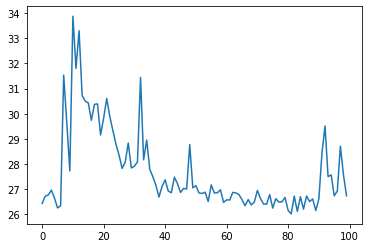

In [32]:
plt.plot(hist3.history['val_loss'])

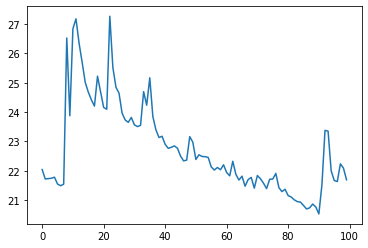

In [33]:
plt.plot(hist3.history['loss'])

In [34]:
model.save('./ocrplus212')

INFO:tensorflow:Assets written to: ./ocrplus212/assets


INFO:tensorflow:Assets written to: ./ocrplus212/assets


In [35]:
!zip -r ./ocrplus212.zip ./ocrplus212

  adding: ocrplus212/ (stored 0%)
  adding: ocrplus212/variables/ (stored 0%)
  adding: ocrplus212/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: ocrplus212/variables/variables.index (deflated 73%)
  adding: ocrplus212/assets/ (stored 0%)
  adding: ocrplus212/keras_metadata.pb (deflated 94%)
  adding: ocrplus212/saved_model.pb (deflated 90%)


In [38]:
pred_model = Model(model.get_layer(name='image').input, model.get_layer(name='dense2').output)
guesses,preds = decode_preds(pred_model,1200,1220)

In [39]:
guesses

['Neg',
 '--- Aa',
 'F',
 'W',
 '---, M',
 '2',
 'N n, Ja',
 'Ca M',
 'F',
 'Can, Ma',
 'M',
 'Neg',
 'Con ',
 'Ne',
 '---, Ma',
 '2o0',
 'Ne',
 '2',
 'Ne',
 'No ne ']

In [43]:
trues = [''.join([charlist[l-1] for l in lab if l>0]) for lab in lab_tensor_sh[1200:1220]]

In [46]:
np.mean([lev.distance(trues[i],guesses[i])/max(len(trues[i]),len(guesses[i])) for i in range(20)]) #seems bad

0.6357703081232493

In [48]:
np.mean([lev.distance(trues[i],guesses[i]) for i in range(20)]) #seems bad

4.9

In [49]:
fullguesses,fullpreds = decode_preds(pred_model,0,1407)

In [51]:
full_trues = [''.join([charlist[l-1] for l in lab if l>0]) for lab in lab_tensor_sh]

In [53]:
np.mean([lev.distance(full_trues[i],fullguesses[i]) for i in range(1407)])

5.991471215351813

In [55]:
np.mean([lev.distance(full_trues[i],fullguesses[i])/max(len(full_trues[i]),len(fullguesses[i])) for i in range(1407)])

0.6672022754696252

In [57]:
np.mean([len(lab) for lab in full_trues]) #average is 8 char long, and you have to make 6 substitutions...

8.145700071073206

In [58]:
#keep training!

In [59]:
hist4 = model.fit(img_tensor_sh,lab_tensor_sh,validation_split=0.2, epochs=eps)

Epoch 1/100
36/36 [==============================] - 20s 548ms/step - loss: 21.4845 - val_loss: 27.1774
Epoch 2/100
36/36 [==============================] - 20s 546ms/step - loss: 21.1891 - val_loss: 26.8710
Epoch 3/100
36/36 [==============================] - 20s 545ms/step - loss: 21.3967 - val_loss: 27.0989
Epoch 4/100
36/36 [==============================] - 19s 539ms/step - loss: 22.6929 - val_loss: 28.9998
Epoch 5/100
36/36 [==============================] - 19s 540ms/step - loss: 21.7955 - val_loss: 28.2310
Epoch 6/100
36/36 [==============================] - 20s 543ms/step - loss: 21.9475 - val_loss: 28.1937
Epoch 7/100
36/36 [==============================] - 19s 542ms/step - loss: 21.6681 - val_loss: 27.9258
Epoch 8/100
36/36 [==============================] - 19s 541ms/step - loss: 21.6772 - val_loss: 27.8044
Epoch 9/100
36/36 [==============================] - 19s 541ms/step - loss: 21.6708 - val_loss: 28.0490
Epoch 10/100
36/36 [==============================] - 19s 540ms/

KeyboardInterrupt: ignored